In [32]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import plotnine as p9
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 15
# import holoviews as hv
# from holoviews import opts
# hv.extension('bokeh')
# opts.defaults(opts.Curve(width=800, framewise=True,tools=['hover'],toolbar='above'),opts.Overlay(legend_position='right'))

## Data Loading

### The data is given as two separate files, one for train and another for test. The way we will process this is:

1. Read in both train and test data files separately
2. To the train data, add a column named "train_data" with all values "True"
3. To the test data, add a column named "train_data" with all values "False"
(Step 2 and 3 enable splitting the exact same data into train and test)
4. Columns which have majority values NA will be dropped
5. For other columns which have lower proportion of NA, they will be filled
6. KNN imputation can be used. However, to keep it simple, I will do: Fill NA in numerical columns with the median value of that column. Fill NA in categorical column with "None"
7. Separate out the train and test data again using the criteria (new column) created in Step 2 and 3
8. Create the datasets X_train, y_train, X_test, y_test by separating the predictor and target variables
9. Set the xgBoost hyperparameters for regression
10. Write a function to run the model and output the result and model performance
11. Output the rersults in the suitable form as prescribed for submission (submission.csv)

#### Read the train and test data

**This is the house price dataset

In [2]:
trainDF = pd.read_csv("train.csv")
unseenDataDF = pd.read_csv("test.csv")

print(trainDF.head())
print("\n-----------")
print("\n")
print(unseenDataDF.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008     

#### Create a function to:
1. Output the ID column of a given data frame
2. Return the data frame without the ID column


In [3]:
def outputID_dropID(df_in, id_col=None):   ## input has to be a data frame
    if id_col is not None:
        if id_col in df_in.columns.values:
            saveIDcol = df_in[id_col]
            df_in.drop(id_col, axis=1, inplace=True)
            return saveIDcol, df_in
        else:
#             print("Column not found..check column name")
            saveIDcol = None
            return saveIDcol, df_in
    else:
        saveIDcol = None
        return saveIDcol, df_in

In [4]:
## store the ID column of the train data
trainId, trainDF = outputID_dropID(trainDF,id_col='Id')  # this works well

## store the ID column of the unseen data to create the submission file
unseenDataId, unseenDataDF = outputID_dropID(unseenDataDF,id_col='Id')  # this works well

In [5]:
trainDF.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Create a function to:
1. Output the target column of a given data frame (typically used to take out the target variable in a training data set
2. Return the data frame without the target column


In [6]:
def outputTarget_dropTarget(df_in, target_col=None):   ## input has to be a data frame
    if target_col is not None:
        if target_col in df_in.columns.values:
            saveTargetcol = df_in[target_col]
            df_in.drop(target_col, axis=1, inplace=True)
            return saveTargetcol, df_in
        else:
#             print("Column not found..check column name")
            saveTargetcol = None
            return saveTargetcol, df_in
    else:
        saveTargetcol = None
        return saveTargetcol, df_in

In [7]:
## Extract target from trainDF
target, trainDF = outputTarget_dropTarget(df_in=trainDF,target_col='SalePrice')
# target

In [8]:
#adding an extra variable to training and testing dataset before joining them, so that they can later be split exactly as given
trainDF['train_set'] = True
unseenDataDF['train_set'] = False

In [9]:
# concatenate both dataframes prior to data preprocessing
fullDF = pd.concat([trainDF, unseenDataDF])
fullDF.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,train_set
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,True
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,True
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,True
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,True
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,True


In [10]:
# let's break down the columns by their type (i.e. int64, float64, object)
fullDF.columns.to_series().groupby(fullDF.dtypes).groups

{dtype('bool'): Index(['train_set'], dtype='object'),
 dtype('int64'): Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
        'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
        'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
        'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
       dtype='object'),
 dtype('float64'): Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
        'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
        'GarageCars', 'GarageArea'],
       dtype='object'),
 dtype('O'): Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'Exte

### Data preprocessing

#### Handling missing values

In [11]:
perc_na = (fullDF.isnull().sum()/len(fullDF))*100
ratio_na = perc_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :ratio_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageFinish,5.447071
GarageQual,5.447071
GarageCond,5.447071
GarageYrBlt,5.447071


#### The variables with the most percentage of missing values (>20%) are:

PoolQC with 99.5%

MiscFeature with 96.30%

Alley with 93.77%

Fence with 80.75%

FireplaceQu with 47.26%

In [12]:
# dropping variables with >20% missing values
fullDF.drop('PoolQC', axis=1, inplace=True)
fullDF.drop('MiscFeature', axis=1, inplace=True)
fullDF.drop('Alley', axis=1, inplace=True)
fullDF.drop('Fence', axis=1, inplace=True)
fullDF.drop('FireplaceQu', axis=1, inplace=True)

#### For the rest of the colums, we will replace the missing values with:

1. median value of that column if it is a numerical variable
2. "None" if it is a categorial variable

In [13]:
# let's list all the numeric columns from df_training
numeric_variables = list(fullDF.select_dtypes(include=['int64', 'float64']).columns.values)
# Apply per-column median of that columns and fill with that value
fullDF[numeric_variables] = fullDF[numeric_variables].apply(lambda x: x.fillna(x.median()),axis=0)

In [14]:
# let's list all the non-numerical columns from df_training
categorial_variables = list(fullDF.select_dtypes(exclude=['int64', 'float64', 'bool']).columns.values)
# Apply per-column median of that columns and fill with that value
fullDF[categorial_variables] = fullDF[categorial_variables].apply(lambda x: x.fillna("None"),axis=0)

In [15]:
# let's check that we no longer have any missing values
perc_na = (fullDF.isnull().sum()/len(fullDF))*100
ratio_na = perc_na.sort_values(ascending=False)
missing_data = pd.DataFrame({'missing_ratio' :ratio_na})
missing_data = missing_data.drop(missing_data[missing_data.missing_ratio == 0].index)
missing_data.head(5)

## check OK..no variables with missing values

,missing_ratio


#### Encode the categorical variables as "int" because regression using xgBoost cannot work with categorical variables encoded as Strings

In [16]:
## First, convert them to categorical - NOTE: This is not used because xgBoost can work with 'object' type columns.
## However, leaving the code here for future help

# fullDF[fullDF.select_dtypes(['object']).columns] = fullDF.select_dtypes(['object']).apply(lambda x: x.astype('category'))
# print(fullDF.shape,target.shape)

In [17]:
# fullDF.dtypes

In [18]:
# ## split the data back into training and unseen data
# trainDF = fullDF[fullDF['train_set']==True]
# trainDF = trainDF.drop('train_set', axis=1)
# unseenDataDF = fullDF[fullDF['train_set']==False]
# unseenDataDF = unseenDataDF.drop('train_set', axis=1)

In [19]:
## use sklearn LabelEncoder to convert categorical data to numeric
## code taken from https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

# # # With this, you now retain all columns LabelEncoder as dictionary...CURRENTLY NOT USED
# # d = defaultdict(LabelEncoder)

# # Encoding the variable
# fullDF_encoded = fullDF.apply(lambda x: d[x.name].fit_transform(x))

fullDF_encoded = deepcopy(fullDF)
# # Inverse the encoded
# fit.apply(lambda x: d[x.name].inverse_transform(x))

# # Using the dictionary to label future data
# df.apply(lambda x: d[x.name].transform(x))

for col in fullDF_encoded.columns:
    if (is_string_dtype(fullDF_encoded[col])):
        fullDF_encoded[col] = LabelEncoder().fit_transform(y=fullDF_encoded[col].values)

fullDF_encoded.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,train_set
0,60,4,65.0,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,9,4,True
1,20,4,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,9,4,True
2,60,4,68.0,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,9,4,True
3,70,4,60.0,9550,1,0,3,0,0,0,...,272,0,0,0,0,2,2006,9,0,True
4,60,4,84.0,14260,1,0,3,0,2,0,...,0,0,0,0,0,12,2008,9,4,True


#### Now split the data back into train and unseen data

In [20]:
trainDF = fullDF_encoded[fullDF_encoded['train_set']==True]
trainDF = trainDF.drop('train_set', axis=1)
unseenDataDF = fullDF_encoded[fullDF_encoded['train_set']==False]
unseenDataDF = unseenDataDF.drop('train_set', axis=1)

In [21]:
## check
print(trainDF.head())
print("\n\n------")
print(trainDF.shape)

   MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
0          60         4         65.0     8450       1         3            3   
1          20         4         80.0     9600       1         3            3   
2          60         4         68.0    11250       1         0            3   
3          70         4         60.0     9550       1         0            3   
4          60         4         84.0    14260       1         0            3   

   Utilities  LotConfig  LandSlope      ...        OpenPorchSF  EnclosedPorch  \
0          0          4          0      ...                 61              0   
1          0          2          0      ...                  0              0   
2          0          4          0      ...                 42              0   
3          0          0          0      ...                 35            272   
4          0          2          0      ...                 84              0   

   3SsnPorch  ScreenPorch  PoolA

In [22]:
unseenDataDF.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,3,80.0,11622,1,3,3,0,4,0,...,0,0,0,120,0,0,6,2010,9,4
1,20,4,81.0,14267,1,0,3,0,0,0,...,36,0,0,0,0,12500,6,2010,9,4
2,60,4,74.0,13830,1,0,3,0,4,0,...,34,0,0,0,0,0,3,2010,9,4
3,60,4,78.0,9978,1,0,3,0,4,0,...,36,0,0,0,0,0,6,2010,9,4
4,120,4,43.0,5005,1,0,1,0,4,0,...,82,0,0,144,0,0,1,2010,9,4


In [23]:
print(trainDF.shape, unseenDataDF.shape)

(1460, 74) (1459, 74)


## Fitting the xGBoost model

In [25]:
## import relevant libraries from sklearn
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

### Now keep aside the unseen data for later use and split the training data into train and test subsets


In [26]:
## The target varialbe from the train data has already been taken out. Save it as Y
Y = target
X = trainDF

## log transform the Y variable
Y = np.log10(Y)

## if you want to use the sqrt transform
# Y = np.sqrt(Y)

# split data into train and test sets
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)  ## train_test_split() is from sklearn

### Define the model and set the hyperparameters

In [27]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=10000,
 max_depth=8,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'reg:linear',
 nthread=4,
 seed=27)

# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 10, 6


# ## Fit the model and get the fitted model and unseen target predictions
# fittedModel, targetUnseenPred = modelfit(xgb2, y_train,X_train,X_test,y_test,predictUnseen=True,unseenData=dataToPredict)

In [28]:
## selecting boosting rounds using cross validation
xgb_param = xgb1.get_xgb_params()
xgtrain = xgb.DMatrix(X_train.values, label=y_train.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb1.get_params()['n_estimators'], nfold=5,\
                    metrics='rmse', early_stopping_rounds=2000, verbose_eval=False)

In [29]:
## set the value of the xgboost parameters returned during the cross validation 
xgb1.set_params(n_estimators=cvresult.shape[0])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=188,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.75)

In [30]:
# Fit the model
xgb1.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)])
y_test_pred = xgb1.predict(X_test)

# print("Accuracy : {:f}".format(metrics.accuracy_score(y_test.values, y_test_pred))) # here, metrics() is from sklearn library
print('\nRoot Mean Square Error = ', mean_squared_error(y_test,y_test_pred)**0.5)

[0]	validation_0-rmse:4.26037
[1]	validation_0-rmse:3.83644
[2]	validation_0-rmse:3.45522
[3]	validation_0-rmse:3.11175
[4]	validation_0-rmse:2.80243
[5]	validation_0-rmse:2.52475
[6]	validation_0-rmse:2.27376
[7]	validation_0-rmse:2.04924
[8]	validation_0-rmse:1.84607
[9]	validation_0-rmse:1.66312
[10]	validation_0-rmse:1.49931
[11]	validation_0-rmse:1.35156
[12]	validation_0-rmse:1.21785
[13]	validation_0-rmse:1.09744
[14]	validation_0-rmse:0.989487
[15]	validation_0-rmse:0.891512
[16]	validation_0-rmse:0.803957
[17]	validation_0-rmse:0.725224
[18]	validation_0-rmse:0.653544
[19]	validation_0-rmse:0.589497
[20]	validation_0-rmse:0.532465
[21]	validation_0-rmse:0.481148
[22]	validation_0-rmse:0.434963
[23]	validation_0-rmse:0.393304
[24]	validation_0-rmse:0.356189
[25]	validation_0-rmse:0.322466
[26]	validation_0-rmse:0.292293
[27]	validation_0-rmse:0.265224
[28]	validation_0-rmse:0.240734
[29]	validation_0-rmse:0.218999
[30]	validation_0-rmse:0.199905
[31]	validation_0-rmse:0.18213
[

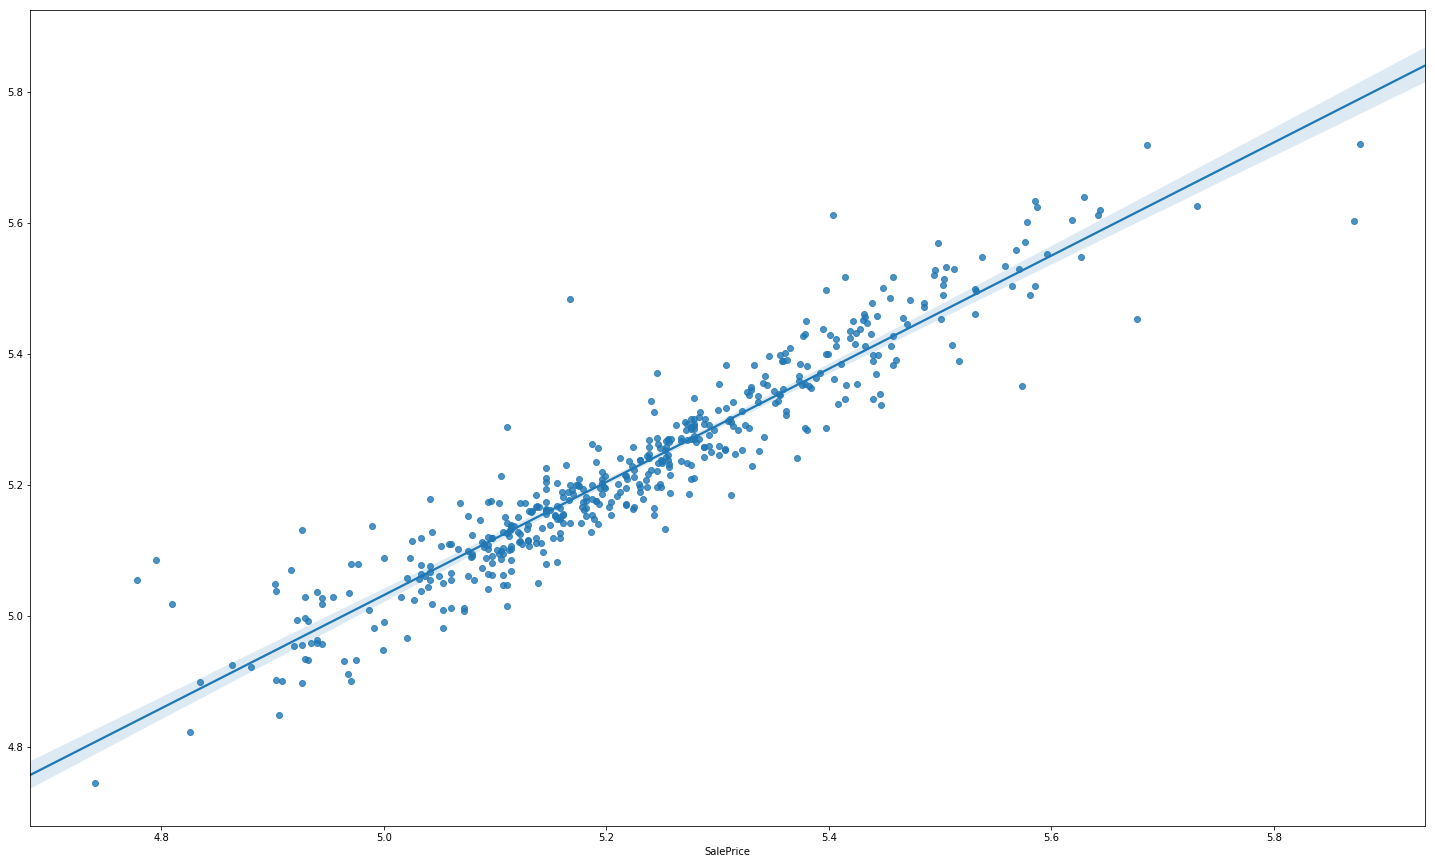

In [33]:
import seaborn as sns

sns.regplot(y_test,y_test_pred)

In [34]:
# make predictions on unseen data
targetUnseenPred = xgb1.predict(unseenDataDF)

In [35]:
finalPredDF = pd.DataFrame()
finalPredDF['ID'] = unseenDataId
finalPredDF['prediction'] = targetUnseenPred #targetUnseenPred

## convert the log10 values of prediction into actual values of target
finalPredDF['prediction'] = finalPredDF['prediction'].apply(lambda x: 10**x)

## if you have used a sqrt transform:
# finalPredDF['prediction'] = finalPredDF['prediction'].apply(lambda x: x**2)

# finalPredDF.head()

,ID,prediction
0,1461,125976.167264
1,1462,159153.284292
2,1463,186917.445659
3,1464,188555.731978
4,1465,199179.830068


In [242]:
## create the submission file

submissionDF = pd.read_csv("sample_submission.csv")
submissionDF.drop(submissionDF.columns[1],axis=1,inplace=True)

submissionDF = submissionDF.merge(finalPredDF,how='left',left_on='Id',right_on='ID',left_index=False,right_index=False)
submissionDF.drop(['ID'],axis=1,inplace=True)
submissionDF.rename(columns={'prediction':'SalePrice'},inplace=True)
submissionDF.head()

,Id,SalePrice
0,1461,130335.250000
1,1462,148091.109375
2,1463,184532.656250
3,1464,190964.625000
4,1465,182764.781250


In [243]:
from datetime import datetime as DateTime  # use this module just to get unique submission file names. See below
submissionFileName = "sanjyot_submission_xgbFinal_" + (str(DateTime.now().time())[0:8]).replace(':','-') + '.csv'
submissionDF.to_csv(submissionFileName,index=False)